In [107]:
from typing import List,NamedTuple,Dict
from collections import Counter
from sklearn.datasets import load_iris
from collections import defaultdict
import numpy as np
Vector=List[float]

In [108]:
def parse_iris_row(row:tuple)-> List[list]:
    dataset=[float(value) for value in row[0]]
    dataset.append(row[1])

    return dataset

def getVectors(data):
    X=[np.array(value[:-1]) for value in data]
    Y=[np.array(value[-1]) for value in data]
    return X,Y

def group_class(dataset):
    point_by_species:Dict[str,List[Vector]]=defaultdict(list)

    for data in dataset:
        point_by_species[data[-1]].append(data[:-1])

    return point_by_species

def plotIris(point_by_species):
    from matplotlib import pyplot as plt
    metrics=["длн.чашелистика","шир.чашелистика","длн.лепестка","шир.лепестка"]
    pairs=[(0,1),(2,3)]
    class_name=["virginica","versicolor","setosa"]


    fig,ax=plt.subplots(1,2,figsize=(10,5))

    #ax.figure(figsize=(10, 10))

    for col in range(2):
        i,j=pairs[col]
        ax[col].set_title(f"{metrics[0]}-{metrics[1]}")
        for (label,points) in point_by_species.items():
            xs=[point[i] for point in points]
            ys=[point[j] for point in points]
            ax[col].scatter(xs,ys,label=class_name[label])

    ax[-1].legend(loc='lower right',prop={'size':10})
    plt.show()


In [109]:
iris = load_iris()
iris_data=[parse_iris_row(row) for row in zip(iris["data"],iris["target"])]
print(iris_data[0])

[5.1, 3.5, 1.4, 0.2, 0]


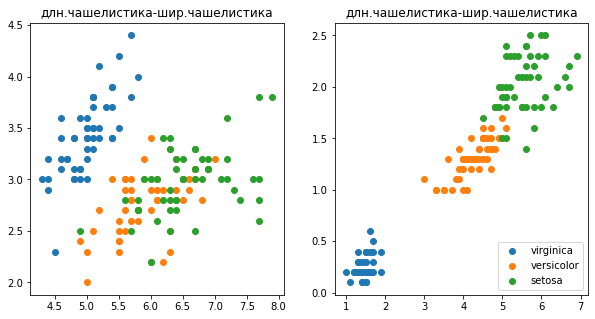

In [110]:
point_by_species=group_class(iris_data)
plotIris(point_by_species)

In [45]:
class KNN:
    @staticmethod
    def euclidean_distance(row1, row2):
        return np.sqrt(np.sum(np.square(row1 - row2)))

    @staticmethod
    def get_neighbors(num_neighbors:int,iris_data:List[list], test_row:List[float]):
        sort_fun=lambda lp:KNN.euclidean_distance(lp[:-1],test_row)

        by_distance=sorted(iris_data,key=sort_fun)

        if num_neighbors>len(by_distance):
            num_neighbors=len(by_distance)

        info_nearest=[[np.array(neighbor[:-1]),neighbor[-1],KNN.euclidean_distance(neighbor[:-1],test_row)]
                              for neighbor in by_distance[:num_neighbors]]


        return info_nearest

    @staticmethod
    def predict_classification(info_nearests):

        labels=[info_nearest[1] for info_nearest in info_nearests]
        vote_counts=Counter(labels)


        winner,winner_count=vote_counts.most_common(1)[0]



        num_winners=len([winner_count
                         for count in vote_counts.values()
                         if count==winner_count])

        if num_winners==1:
            return winner
        else:
            return KNN.predict_classification(info_nearests[:-1])

    @staticmethod
    def predict(k,dataset,value):
        info_nearest=KNN.get_neighbors(k,dataset,value)
        try:
            answer=KNN.predict_classification(info_nearest)
        except:
            answer=None
        return answer


import copy
import random


def split_data(data,cof):
    train_dataset=copy.deepcopy(data)
    random.shuffle(train_dataset)
    step=int(1/cof)
    test_dataset=train_dataset[::step]
    del train_dataset[::step]
    return train_dataset,test_dataset


#test function

In [46]:
#X,Y=getVectors(iris_data)
test_dataset = iris_data[:150:15]
X_input_data=np.array(test_dataset[5][:-1])
Y_input_data=np.array(test_dataset[5][-1])

print("Test euclidean_distance")
for data in test_dataset[:-1]:
    print(KNN.euclidean_distance(np.array(data[:-1]),X_input_data))
print("\nTest get_neighbors")
neighbors=KNN.get_neighbors(3,test_dataset,X_input_data)
for i in neighbors:
    print(i)

print("\nTest predict_classification")
predict=KNN.predict_classification(neighbors)

print(f'Expected {Y_input_data}, Got {predict}.' )

Test euclidean_distance
3.59722114972099
3.4899856733230297
3.539774004085572
3.66742416417845
2.128379665379276
0.0
1.1874342087037915
2.5159491250818244
1.6217274740226855

Test get_neighbors
[array([6.6, 3. , 4.4, 1.4]), 1, 0.0]
[array([5.5, 2.6, 4.4, 1.2]), 1, 1.1874342087037915]
[array([6.9, 3.2, 5.7, 2.3]), 2, 1.6217274740226855]

Test predict_classification
Expected 1, Got 1.


In [47]:
def test_knn(dataset,k=3,test_sample=0.3):
    train_dataset,test_dataset=split_data(dataset,test_sample)

    accuracy=0
    for N,test in enumerate(test_dataset):
        answer=KNN.predict(k,train_dataset,np.array(test[:-1]))

        if answer==test[-1]:
            accuracy+=1
    return accuracy*100/len(test_dataset)


k=3
test_sample=0.3
print(f'k:{k},\ntest_sample={test_sample}')
accuracy=test_knn(iris_data)
print(f"accuracy:{accuracy}")

k:3,
test_sample=0.3
accuracy:98.0


In [48]:
import matplotlib.pyplot as plt

def search_k(dataset,N=60,test_sample=0.3):
    list_accuracy=[]
    for i in range(1,N):
        list_accuracy.append(test_knn(dataset,k=i,test_sample=test_sample))

    plt.figure(figsize=(10, 5))
    plt.plot([i for i in range(len(list_accuracy))],list_accuracy ,marker='o')
    plt.xlabel('k'), plt.ylabel('accuracy')
    plt.title(f'Dependence of the forecast accuracy value on the index k,\nat test_sample={test_sample}')
    plt.show()


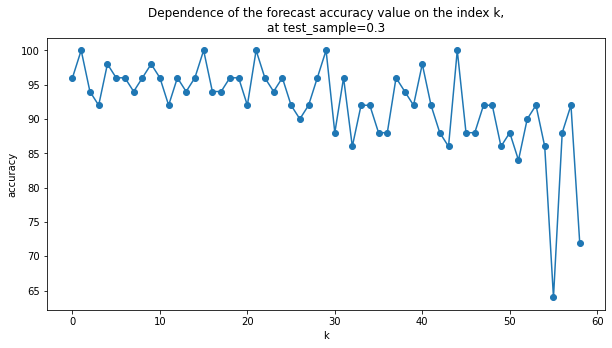

In [33]:
search_k(iris_data,N=60,test_sample=0.3)

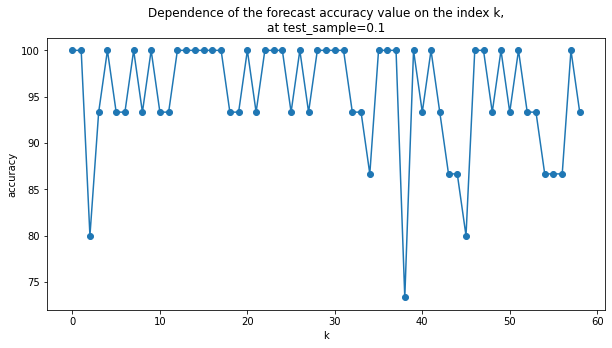

In [34]:
search_k(iris_data,N=60,test_sample=0.1)

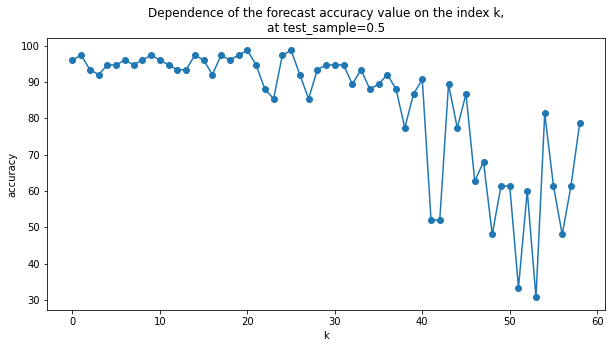

In [35]:
search_k(iris_data,N=60,test_sample=0.5)

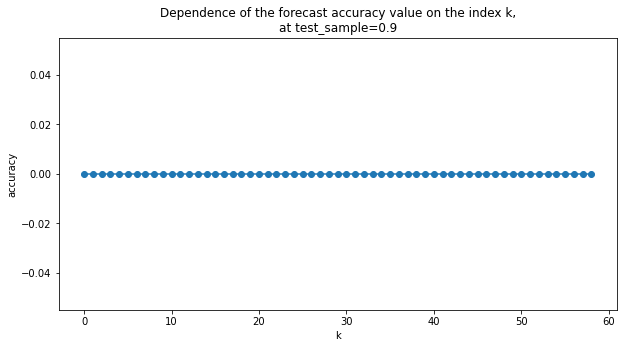

In [36]:
search_k(iris_data,N=60,test_sample=0.9)

The parameter k should be selected depending on the task. If you choose the number of dimensions too large, you can run into the "curse of the dimension" phenomenon. This is due to the fact that the spaces become wide, and the points in such spaces are not close to each other.

It is required to find a balance between bias and variance. If k is large, then there will be a large bias but low variance. If k is low, then the bias will be low, but the variance will be high.

It is also worth taking a responsible approach to choosing the ratio of the test and training samples. The ratio must be taken so that there is a balance between accuracy during training and testing. If you take too large a training sample, then there will be a big error during testing. Also, if you take a large test sample, the model will not predict the values well.

##sklearn

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import  StandardScaler
import numpy as np

In [97]:
def test_sklearn_knn(dataset,k=3,test_sample=0.3):
    train_dataset,test_dataset=split_data(dataset,test_sample)
    X_train,Y_train=getVectors(train_dataset)
    X_test,Y_test=getVectors(test_dataset)

    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1,metric="euclidean")
    knn.fit(X_train,Y_train)

    X_test=scaler.fit_transform(X_test)
    answer=knn.predict(X_test)

    accuracy=sum(int(x == y) for (x, y) in zip(answer,Y_test))

    return accuracy*100/len(test_dataset)

test_sklearn_knn(iris_data)

96.0

In [106]:
from sklearn.linear_model import LogisticRegression

def test_sklearn_logistic(dataset,test_sample=0.3):
    train_dataset,test_dataset=split_data(dataset,test_sample)
    X_train,Y_train=getVectors(train_dataset)
    X_test,Y_test=getVectors(test_dataset)

    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    model = LogisticRegression(random_state=0)
    model.fit(X_train,Y_train)

    X_test=scaler.fit_transform(X_test)
    answer=model.predict(X_test)

    accuracy=sum(int(x == y) for (x, y) in zip(answer,Y_test))

    return accuracy*100/len(test_dataset)

test_sklearn_logistic(iris_data)



98.0

The problem of classification can be solved by different methods. In this case, the knn method and logical regression are considered.
All of them show good accuracy.